## Imports & Loading the data

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error

In [2]:
# Matplotlib configuration
plt.rcParams['figure.figsize'] = [15, 7]
# Pandas configuration
pd.options.display.max_rows = 100 # For debugging, can be removed later

In [3]:
data_subsets_splitted_joined = pickle.load(open('splitted_joined_data.pickle', 'rb'))
sj_train_train, sj_train_test, iq_train_train, iq_train_test = data_subsets_splitted_joined

In [4]:
# function for evaluation of models
def model_classification(actual, predicted): 
    """
    Prints out RSME, MAE and explained variance score
    """
    print('-'*20)
    print(f'RMSE: {round(np.sqrt(mean_squared_error(actual, predicted)),2)}')
    print('-'*20)
    print(f'MAE: {round(mean_absolute_error(actual, predicted),2)}')
    print(f'Explained variance: {round(explained_variance_score(actual, predicted),3)}')
    print('-'*20)

## Wisorizing

In [5]:
def winsorizer(df, colname, clip_upper, time_ratio=0.5):
    '''
    Inputs:
    df: dataframe
    colname: name of the variable to be winsorised
    clip_upper: where to clip the values in proportion to the global maximum,
    e.g. 0.8 => clip the values above 80% of the global maximum of the variable
    ratio: what portion of the series should be winsorised, 
    e.g. 0.3 => the first third of the series is modified.
    Output: the dataframe with one modified variable
    '''
    early = df.iloc[:round(df.shape[0]/(1/time_ratio)),:]
    late = df.iloc[round(df.shape[0]/(1/time_ratio)):,:]
    clipped_var = early[colname].clip(upper=max(df[colname])*clip_upper)
    df[colname] = pd.concat([clipped_var, late[colname]])
    return df

In [6]:
sj_train_train = winsorizer(sj_train_train, 'total_cases', clip_upper=0.8, time_ratio=0.5)
iq_train_train = winsorizer(iq_train_train, 'total_cases', clip_upper=0.8, time_ratio=0.5)

## Extracting the seasonality 

In [7]:
# This is for now fixed to a 3 week centered rolling mean, should later be generalised!

def get_smooth_seasonality_df(df, colnames):
    '''
    Inputs:
    df: dataframe with the variables 'year' and 'weekofyear'
    colnames: a list of names of variables for which to get the seasonality
    Output:
    Pandas dataframe with seasonalities
    '''
    if type(colnames) == str:
        colnames = [colnames]
    l = []
    for i in range(len(colnames)):
        weekly_median = (
            df
            .pivot(index='weekofyear', columns='year', values=colnames[i])
            .median(axis=1)
        )
        jan = pd.Series(weekly_median[1])
        jan.index = [len(weekly_median)+1]

        dec = pd.Series(weekly_median[len(weekly_median)])
        dec.index = [weekly_median.index[0]-1]

        weekly_median = weekly_median.append(jan)
        weekly_median = weekly_median.append(dec)

        smooth_seasonality = (
            weekly_median
            .sort_index()
            .rolling(window=3, center=True)
            .mean()
            .dropna()
        )
        smooth_seasonality.name = colnames[i]
        l.append(smooth_seasonality)
    
    df = pd.DataFrame(l).T
    df = df.reset_index()
    df = df.rename(columns={'index': 'weekofyear'})
    return df

In [8]:
sj_train_train_seas = get_smooth_seasonality_df(sj_train_train, 'total_cases')
# sj_train_train_seas.head()

## Evaluating the saisonality as a baseline model

In [9]:
def seasonality_for_test(df_test, seas):
    eval_df = (
        df_test
        .loc[:,['weekofyear', 'total_cases']]
        .merge(seas,
               how='left',
               on='weekofyear',
               suffixes=('','_seas')
              )
    )
    return eval_df.iloc[:,2]

In [10]:
seasonality_for_test(sj_train_test, sj_train_train_seas)

0      46.333333
1      45.333333
2      45.666667
3      41.666667
4      38.666667
         ...    
228    11.333333
229    12.000000
230    11.000000
231    10.666667
232     9.666667
Name: total_cases_seas, Length: 233, dtype: float64

In [11]:
def seasonality_baseline_eval(df_test, seas):
    eval_df = (
        df_test
        .loc[:,['weekofyear', 'total_cases']]
        .merge(seas,
               how='left',
               on='weekofyear',
               suffixes=('','_seas')
              )
    )
    (
        eval_df
        .iloc[:,1:]
        .plot()
    )
    model_classification(eval_df.iloc[:,1], eval_df.iloc[:,2])

--------------------
RMSE: 26.96
--------------------
MAE: 18.26
Explained variance: 0.117
--------------------


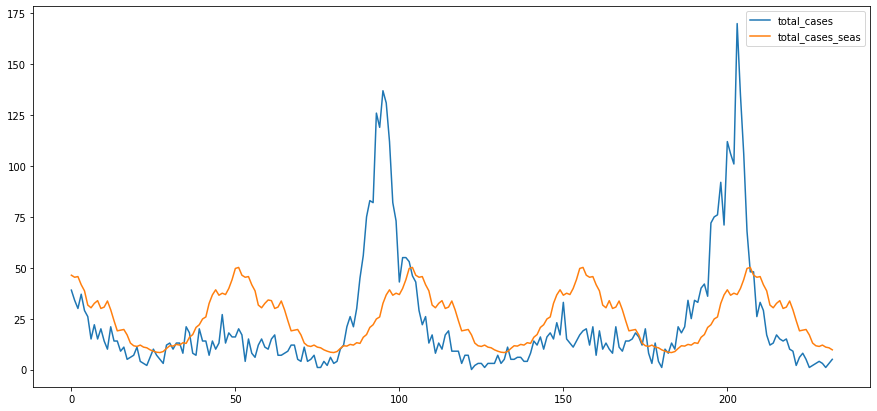

In [12]:
seasonality_baseline_eval(sj_train_test, sj_train_train_seas)

## Substracting the saisonality

In [13]:
def substract_seas(df, var):
    kwargs = {'%s_wo_seas' % var: lambda df: df[var] - df['%s_seas' % var]}
    df_mod = (
        df
        .merge(
            get_smooth_seasonality_df(df, var),
            how='left', 
            on='weekofyear',
            suffixes=('','_seas')
            )
        .assign(**kwargs)
    )
    df_mod.index = df.index
    return df_mod

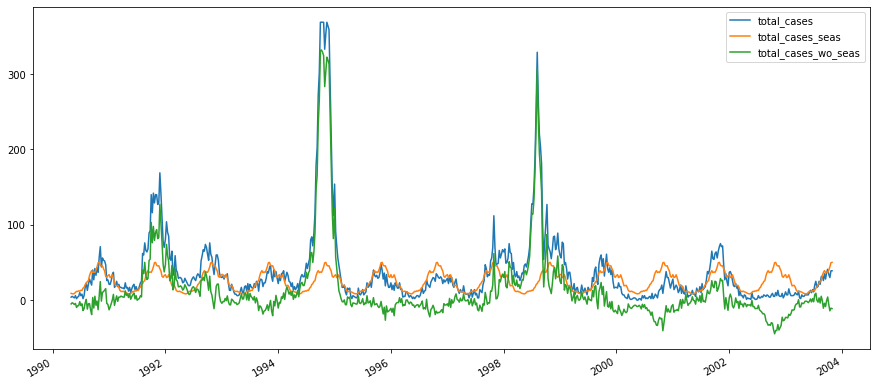

In [14]:
sj_train_train_tc_wo_seas = substract_seas(sj_train_train, 'total_cases')
sj_train_test_tc_wo_seas = substract_seas(sj_train_test, 'total_cases')
(
    sj_train_train_tc_wo_seas
    .loc[:,['total_cases', 'total_cases_seas', 'total_cases_wo_seas']]
    .plot()
);

## Regression (Random Forest)

In [15]:
from sklearn.ensemble import RandomForestRegressor

In [16]:
sj_train_train

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,...,station_min_temp_c,station_precip_mm,month,reanalysis_air_temp_c,reanalysis_avg_temp_c,reanalysis_dew_point_temp_c,reanalysis_max_air_temp_c,reanalysis_min_air_temp_c,population,total_cases
1990-04-30,1990-04-30,sj,1990,18,0.122600,0.103725,0.198483,0.177617,32.00,73.365714,...,20.0,16.0,4,24.422857,24.592857,19.264286,26.65,22.75,2217968,4.0
1990-05-07,1990-05-07,sj,1990,19,0.169900,0.142175,0.162357,0.155486,17.94,77.368571,...,22.2,8.6,5,25.061429,25.292857,20.801429,27.75,23.25,2217968,5.0
1990-05-14,1990-05-14,sj,1990,20,0.032250,0.172967,0.157200,0.170843,26.10,82.052857,...,22.8,41.4,5,25.631429,25.728571,22.284286,27.35,24.15,2217968,4.0
1990-05-21,1990-05-21,sj,1990,21,0.128633,0.245067,0.227557,0.235886,13.90,80.337143,...,23.3,4.0,5,25.837143,26.078571,22.160000,28.25,23.85,2217968,3.0
1990-05-28,1990-05-28,sj,1990,22,0.196200,0.262200,0.251200,0.247340,12.20,80.460000,...,23.9,5.8,5,26.368571,26.514286,22.671429,28.75,24.35,2217968,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003-10-01,2003-10-01,sj,2003,40,-0.033500,0.015100,0.217486,0.208814,11.00,79.355714,...,25.0,9.9,10,28.044286,28.257143,24.117143,30.35,26.35,2403420,41.0
2003-10-08,2003-10-08,sj,2003,41,0.020400,0.032750,0.163443,0.110371,6.30,76.435714,...,24.4,0.8,10,27.782857,27.950000,23.234286,30.05,26.05,2403420,34.0
2003-10-15,2003-10-15,sj,2003,42,0.016100,0.037100,0.243400,0.267729,97.70,80.250000,...,22.8,61.0,10,27.528571,27.678571,23.790000,29.75,25.15,2403420,30.0
2003-10-22,2003-10-22,sj,2003,43,-0.041600,0.055300,0.169929,0.128171,10.70,77.531429,...,23.9,10.9,10,27.940000,28.007143,23.640000,29.75,25.85,2403420,39.0


In [79]:
X_train = (
    sj_train_train
    .drop(['week_start_date',
           'city',
           'year',
           'weekofyear',
           'month',
           'total_cases'], axis=1)
)
X_test = (
    sj_train_test
    .drop(['week_start_date',
           'city',
           'year',
           'weekofyear',
           'month',
           'total_cases'], axis=1)
)
y_train = sj_train_train_tc_wo_seas.total_cases_wo_seas
y_test = sj_train_test_tc_wo_seas.total_cases

In [110]:
rf = RandomForestRegressor(n_estimators=100,
                           max_depth=20,
                           min_samples_split= 5,
                           max_leaf_nodes= 43,
)

In [111]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_leaf_nodes=43, min_samples_split=5)

In [112]:
y_pred = rf.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

In [113]:
test_seas_model = seasonality_for_test(sj_train_test, sj_train_train_seas)
test_seas_model.index = y_test.index 
# test_seas_model

<AxesSubplot:>

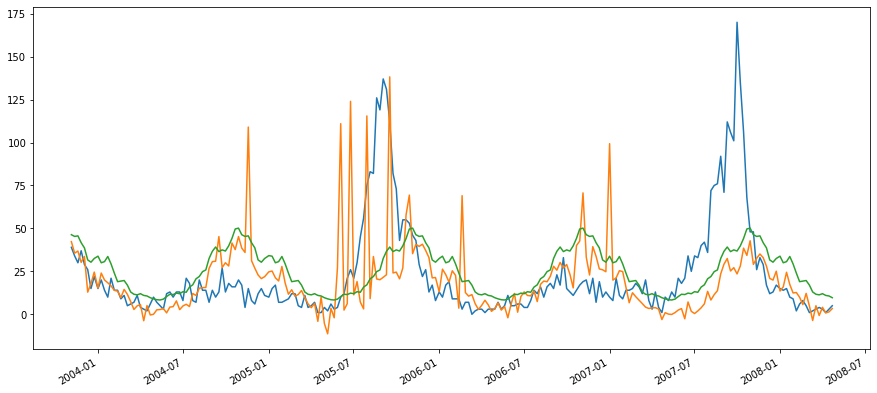

In [114]:
y_pred = y_pred + test_seas_model
y_test.plot()
y_pred.plot()
test_seas_model.plot()

In [115]:
model_classification(y_test, y_pred)

--------------------
RMSE: 30.36
--------------------
MAE: 17.37
Explained variance: -0.117
--------------------


## Substracting the saisonality